<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder)

## 1. Load dataset

## 2. Import python libraries and define util functions

In [1]:
''' import '''
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [3]:
''' device '''
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

device

device(type='mps')

In [14]:
''' path '''
data_path = os.path.join(os.getcwd(), 'dataset')
model_path = os.path.join(os.getcwd(), 'model')

data_path, model_path

('/Users/leejuchan/workspace/study/book/DL2/dataset',
 '/Users/leejuchan/workspace/study/book/DL2/model')

In [30]:
''' function '''
# set random seed (for reproducibility)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# image read
def img_read(src, file):
    img_path = os.path.join(src, file)
    img = cv.imread(img_path, cv.COLOR_BGR2GRAY) # grayscale
    return img

# image read/plot
def img_read_plot(src, file):
    img_path = os.path.join(src, file)
    img = cv.imread(img_path, cv.COLOR_BGR2GRAY) # grayscale

    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return img


# plot loss history
def plot_loss(loss_history, title=None):

    plt.plot(loss_history)

    if title is not None:
        plt.title(title)

    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train data'], loc=0)
    plt.show()

In [31]:
set_seed(0)

## 3. Check dataset

## 4. Convert images into trainable data

In [ ]:
''' load data '''
src = os.path.join(data_path, 'data_3000')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (3000, 56, 56)
Y.shape: (3000,)


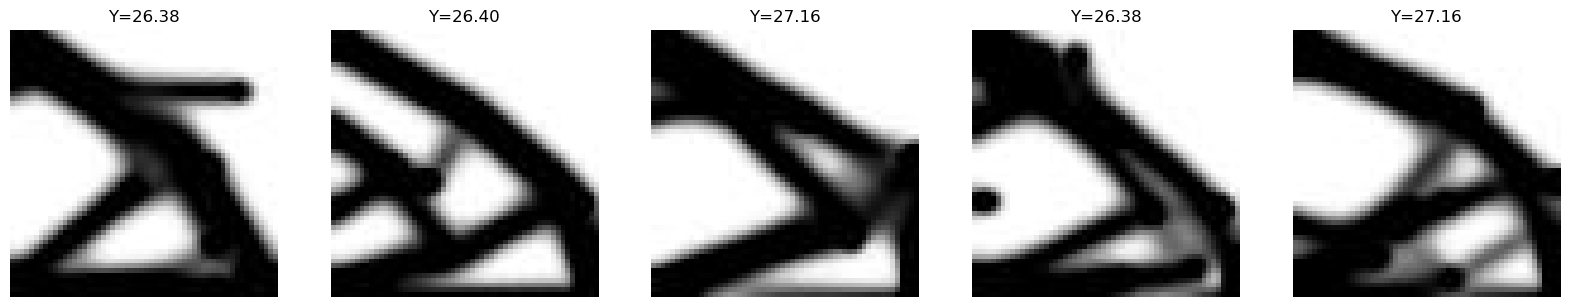

In [ ]:
# check images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1, nplot+1):
    ax = fig.add_subplot(1, nplot, i)
    ax.imshow(X[i,:,:], cmap='gray')
    ax.set_title(f"Y={Y[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [64]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape

((2400, 56, 56), (600, 56, 56), (2400,), (600,))

In [65]:
# reshape (flatten)
X_tr = X_tr.reshape(-1, np.prod(X_tr.shape[1:])) # (2400, 56, 56) -> (2400, 56*56)
X_ts = X_ts.reshape(-1, np.prod(X_ts.shape[1:]))

print(X_tr.shape,X_ts.shape)


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32).to(device)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32).to(device)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

(2400, 3136) (600, 3136)


## 6. Set to model architecture

In [ ]:
''' model '''
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, h_dim),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(h_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, image_size),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

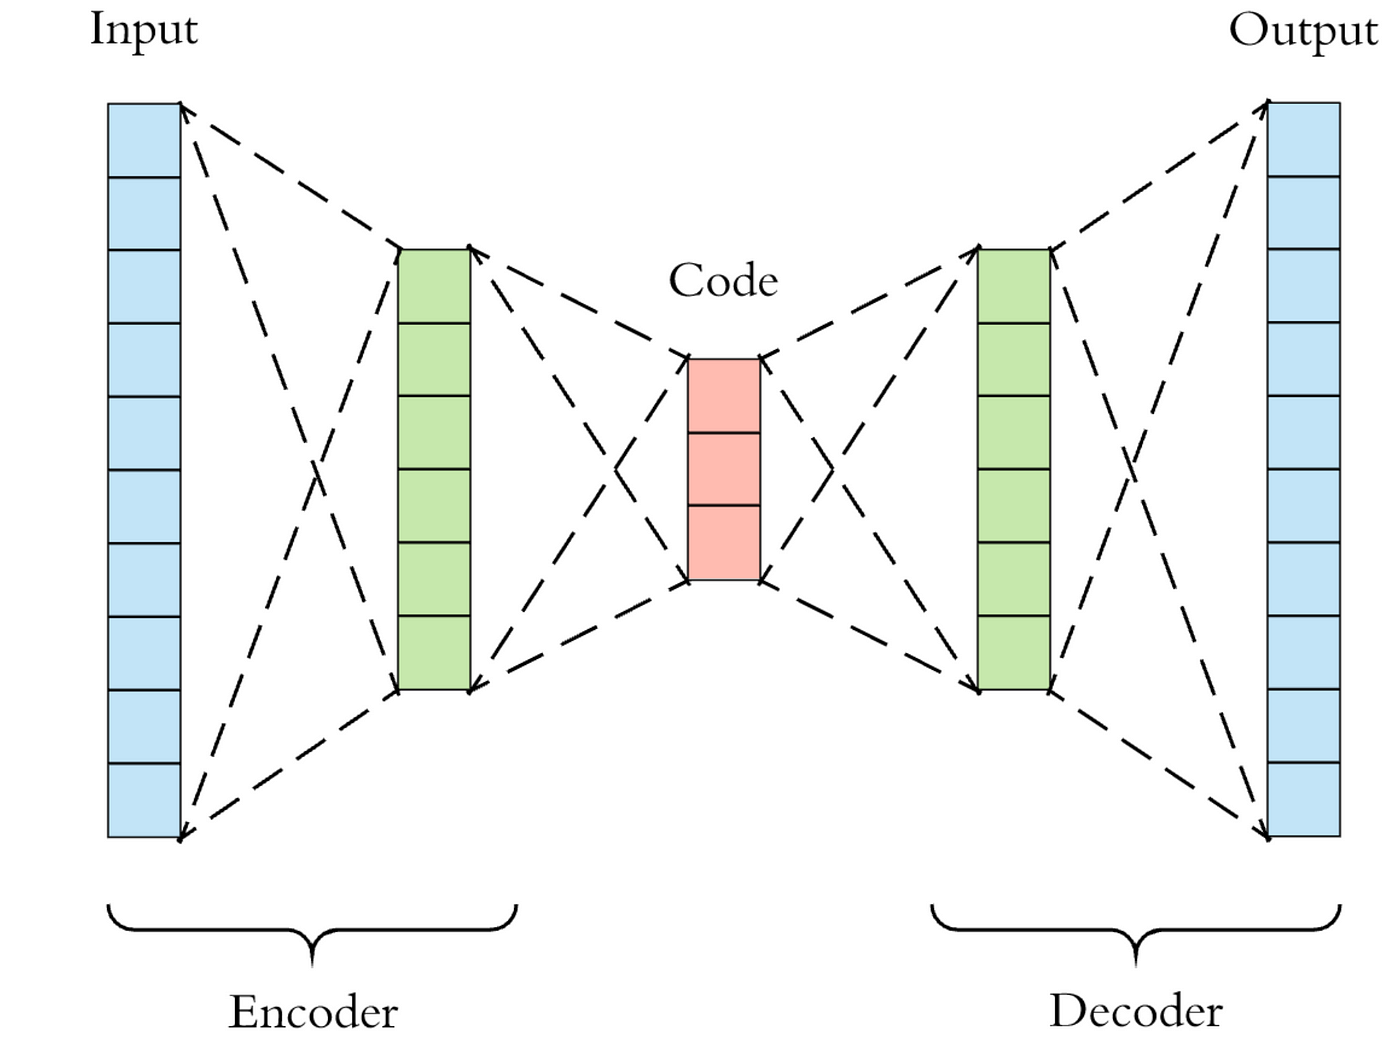

## 7. Set model hyperparameters

In [ ]:
# model architecture parameters
image_size = np.shape(X_tr[0])[0]  # (fixed) input size
mid_dim = 512  # hidden layer(middle) dimension
h_dim = 20  # hidden layer(latent) dimension

# training parameters
num_epochs = 200
batch_size = 20
learning_rate = 1e-3

In [ ]:
autoencoder = Autoencoder().to(device)

# print the model's summary
summary(autoencoder, (image_size,))  # input shape: (channels, height, width)

autoencoder

## 8. Train model

In [ ]:
# create DataLoader for training and validation data
train_dataset = TensorDataset(X_tr, X_tr)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# lists to track training and validation history
loss_train_history = []

# train the model
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # calculate average metrics for the training set
    average_loss_train = total_loss / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train}")

    # perform inference every XX epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        autoencoder.eval()
        recon_x_test = autoencoder(X_ts)

        n = 10  # how many images to display
        plt.figure(figsize=(15, 4)) # figure size

        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(X_ts.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Input{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Recon{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
        plt.show()
        autoencoder.train()  # switch back to training mode

# save the model
torch.save(autoencoder.state_dict(), './model/AE_model.pth')

In [ ]:
# graph visualization
plot_loss(loss_train_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

In [ ]:
autoencoder.eval().to(device)

# proceed reconstruction of the bracket images through the trained autoencoder model
recon_x_test = autoencoder(X_ts)

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_ts.cpu()[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 10. Visualize latent space using t-SNE (t-distributed Stochastic Neighbor Embedding)

In [ ]:
# set the model to evaluation mode to get the encoded representations without gradients
autoencoder.eval()

with torch.no_grad():  # disable gradient computation for inference
    # get the latent representations (encoded features) for the test dataset
    z_test = autoencoder.encoder(X_ts).cpu().detach().numpy()

# apply t-SNE to reduce the latent space to 2 dimensions for visualization
tsne = TSNE(n_components=2, perplexity=40, random_state=0)
z_tsne = tsne.fit_transform(z_test)

# create a scatter plot of the t-SNE results
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=Y_ts, cmap='coolwarm')
plt.colorbar(scatter, ticks=[0, 50], label='Data Label')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Latent Space for Test Data")
plt.show()